<a href="https://www.kaggle.com/code/krishnadeshpande2907/emotional-analysis-of-audio-lstm?scriptVersionId=206170799" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Modules

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import random
import tensorflow as tf
import torch
import torchaudio
import torchaudio.transforms as T
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

### Checking for GPU

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
torch.cuda.device_count()

1

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
import torch
print(torch.cuda.is_available())

True


# Loading the Dataset

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

## TESS

In [11]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [12]:
# Joining them both
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

<Axes: xlabel='Emotions', ylabel='count'>

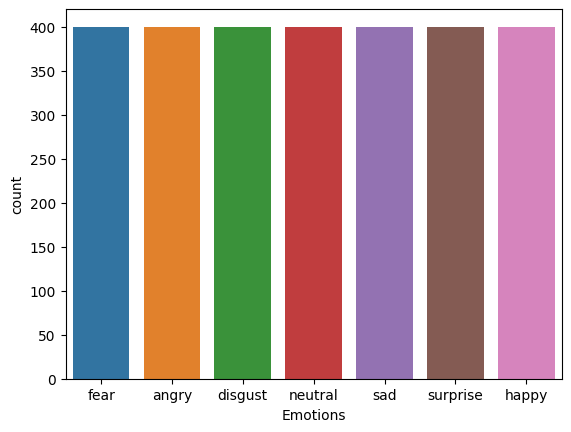

In [13]:
sns.countplot(data=Tess_df, x='Emotions')

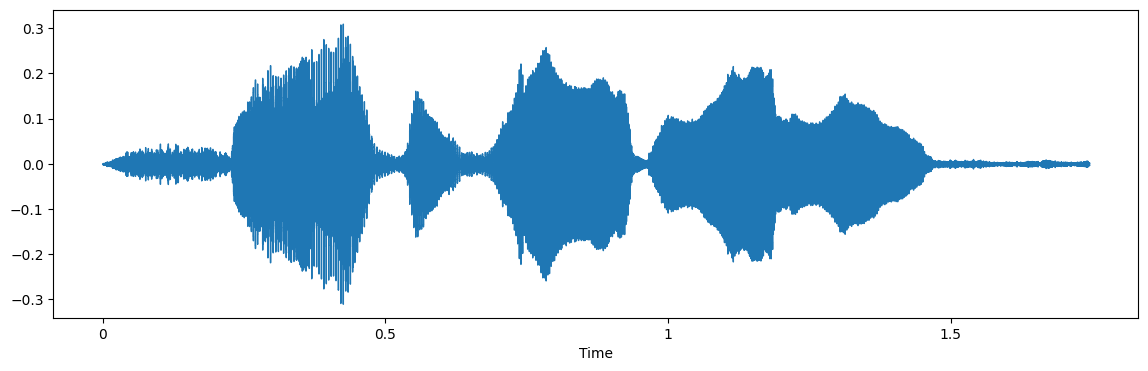

In [14]:
# Sample Audio
path = np.array(Tess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Ravdess

In [15]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [16]:
# Joining them both
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

<Axes: xlabel='Emotions', ylabel='count'>

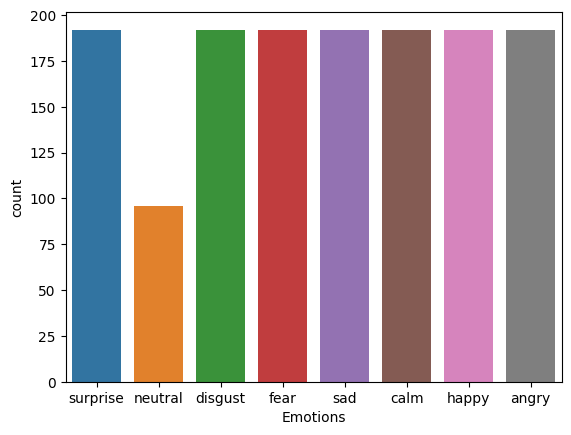

In [17]:
sns.countplot(data=Ravdess_df, x='Emotions')

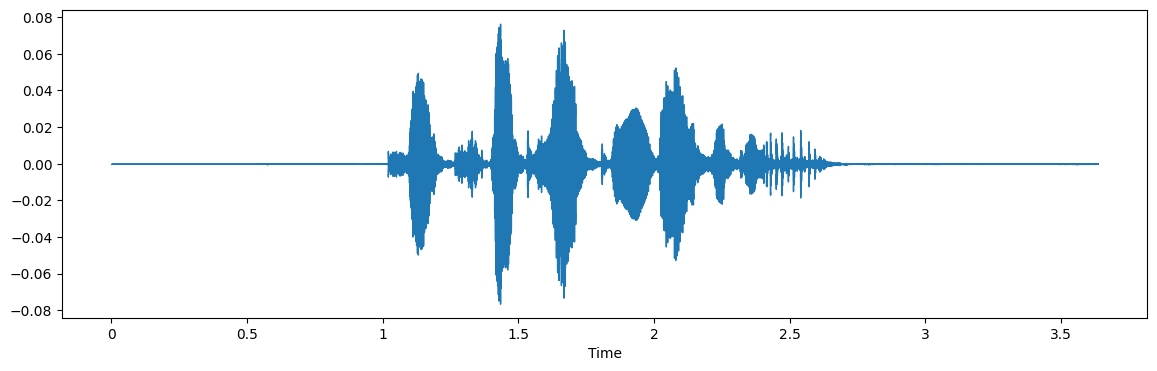

In [18]:
# Sample Audio
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Crema-D

In [19]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [20]:
# Joining them both
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

<Axes: xlabel='Emotions', ylabel='count'>

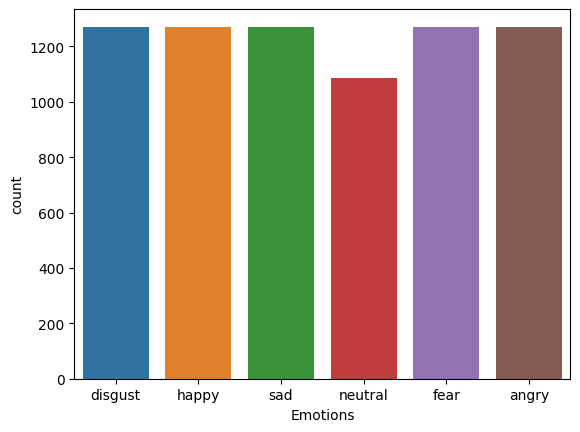

In [21]:
sns.countplot(data=Crema_df, x='Emotions')

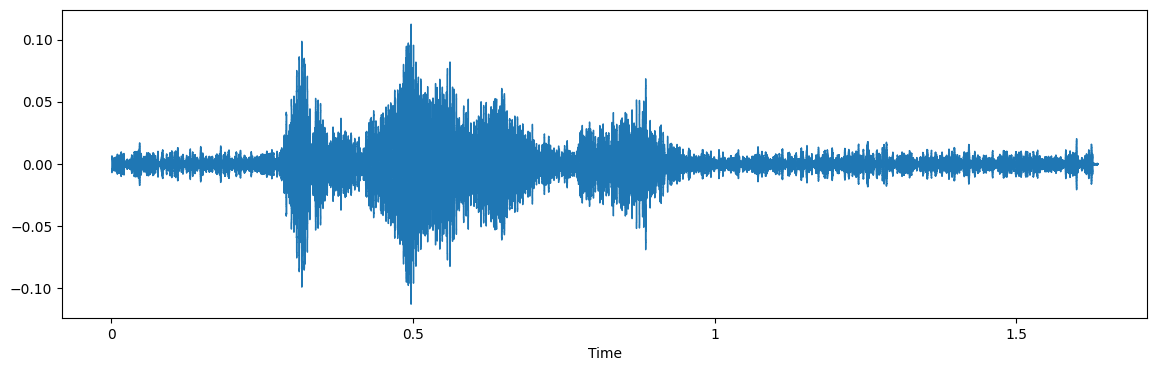

In [22]:
# Sample Audio
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Savee

In [23]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [24]:
# Joining them both
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

<Axes: xlabel='Emotions', ylabel='count'>

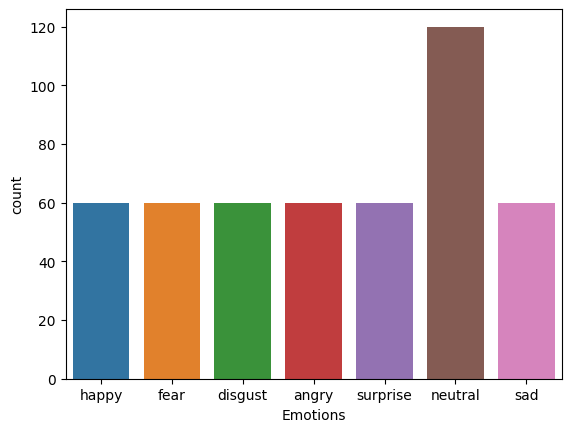

In [25]:
sns.countplot(data=Savee_df, x='Emotions')

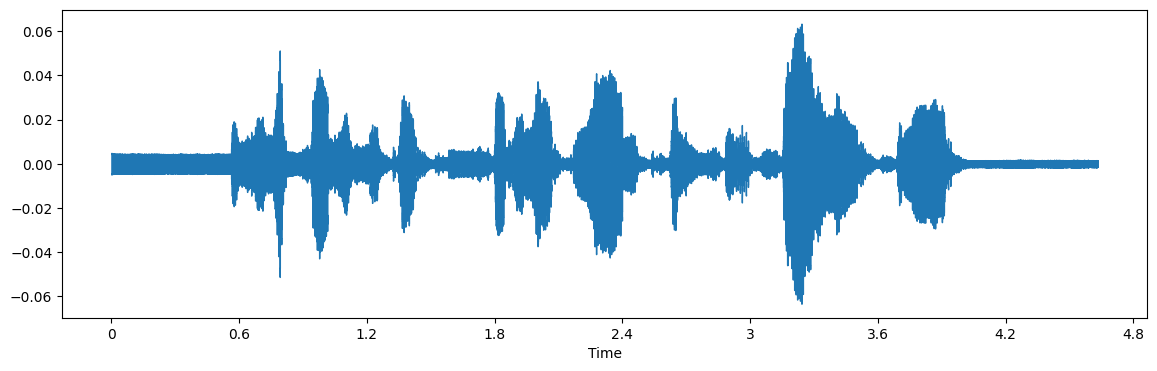

In [26]:
# Sample Audio
path = np.array(Savee_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

# Combining All

In [27]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(12162, 2)

In [28]:
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

<Axes: xlabel='Emotions', ylabel='count'>

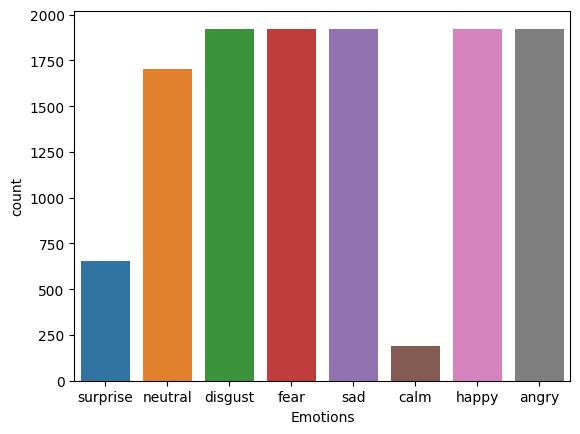

In [29]:
sns.countplot(data=data_path, x='Emotions')

In [30]:
data_path['Emotions'].value_counts()

Emotions
fear        1923
disgust     1923
happy       1923
sad         1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

# Data Pre-Processing

# Exploring labels

In [31]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

### Fear

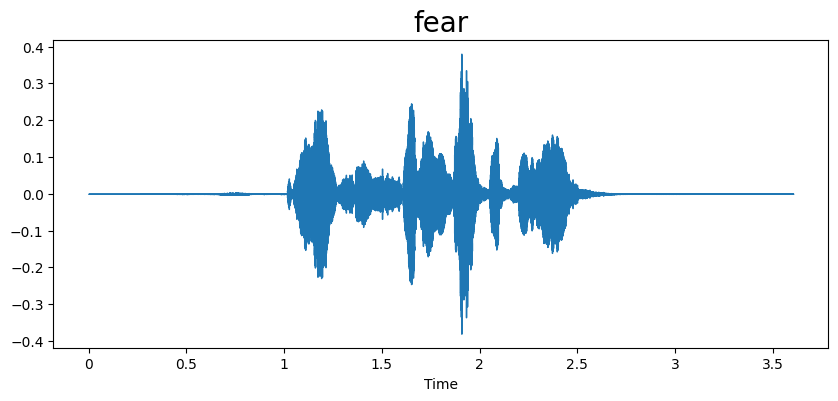

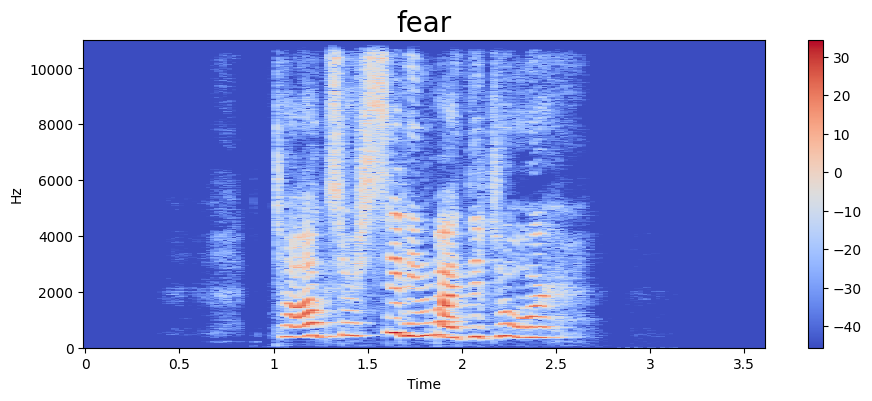

In [32]:
emotion = 'fear'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Anger

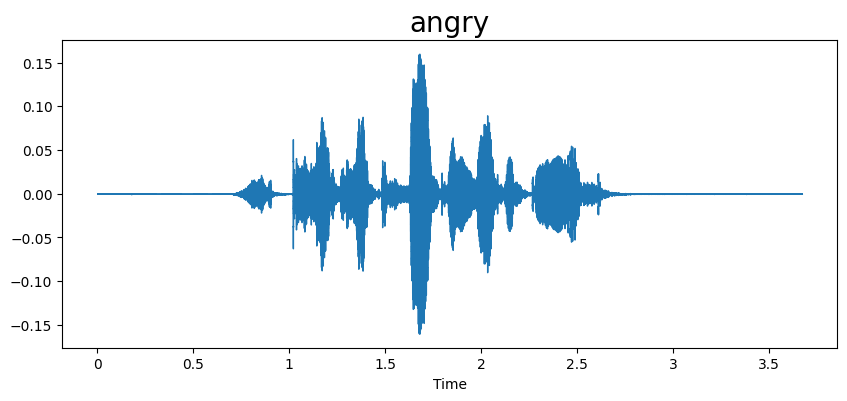

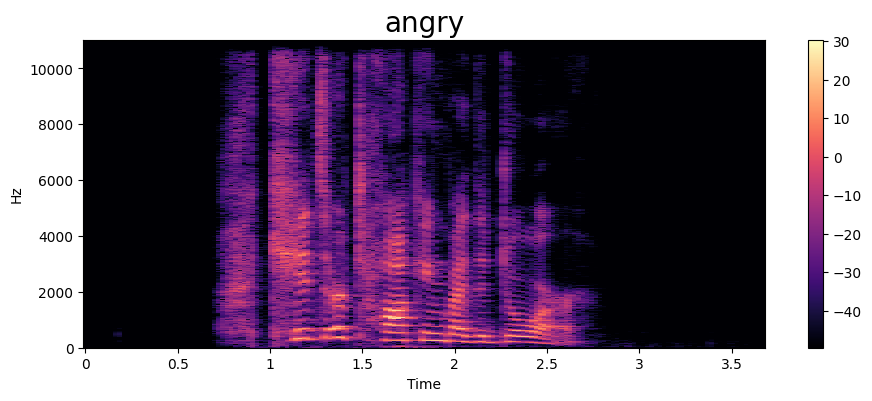

In [33]:
emotion = 'angry'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Disgust

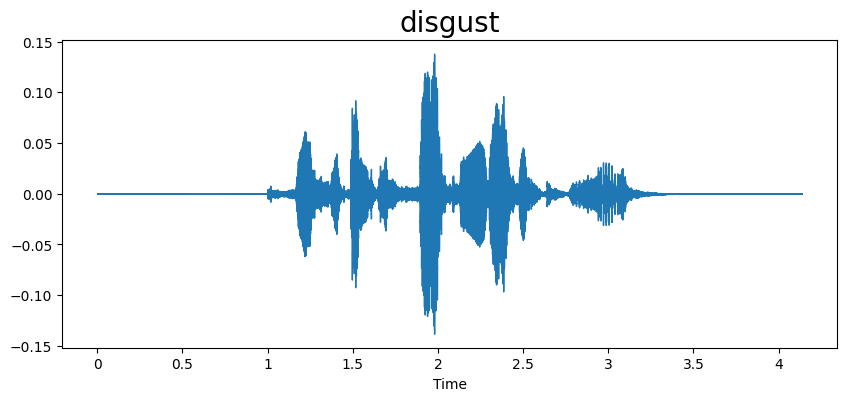

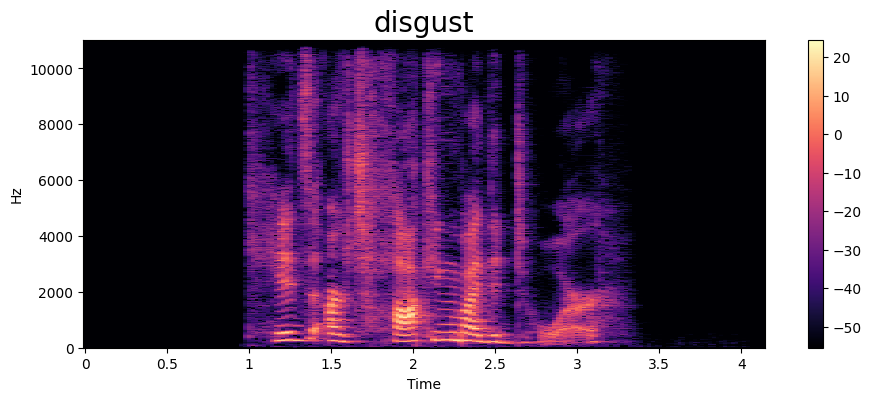

In [34]:
emotion = 'disgust'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Neutral

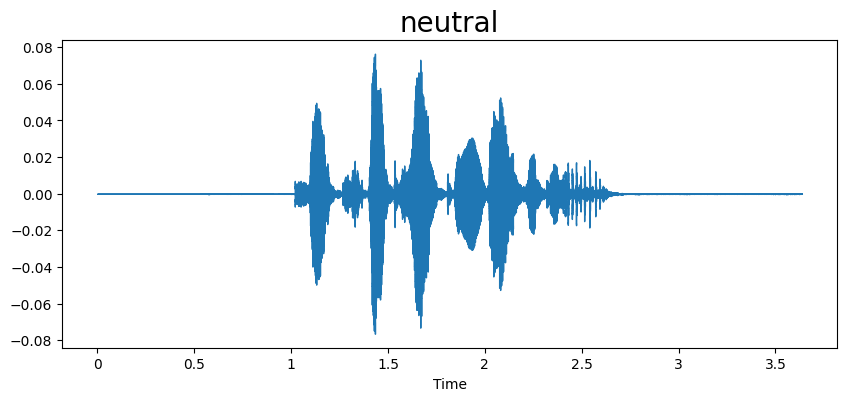

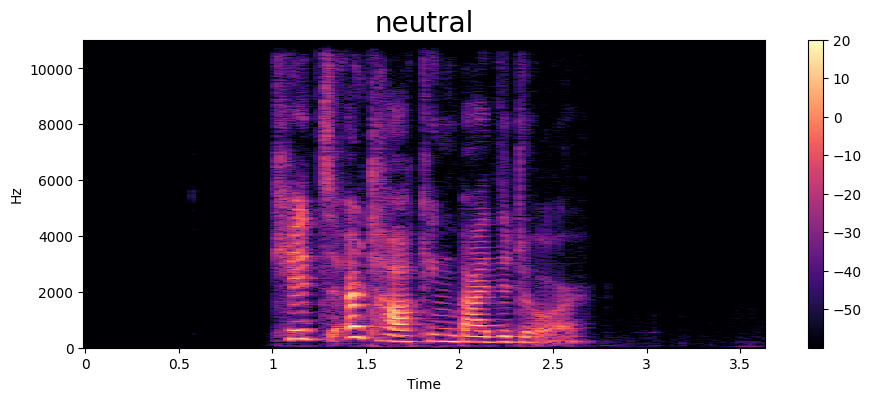

In [35]:
emotion = 'neutral'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Sad

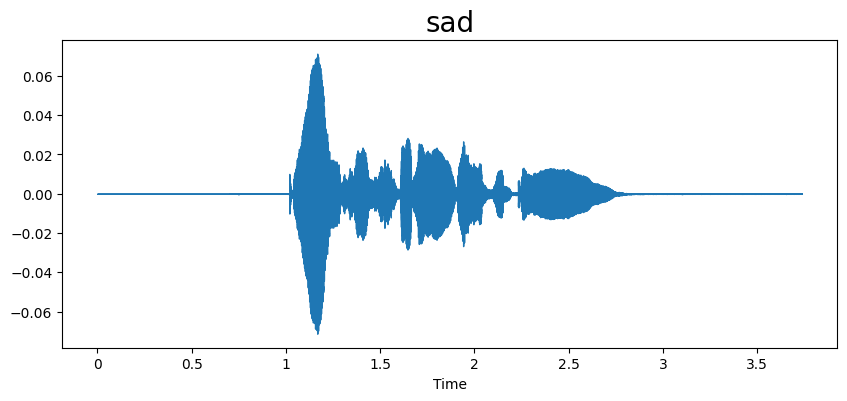

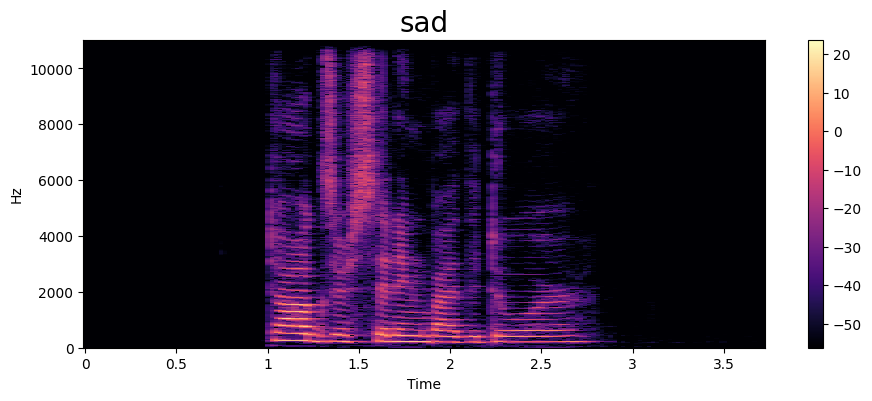

In [36]:
emotion = 'sad'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Happy

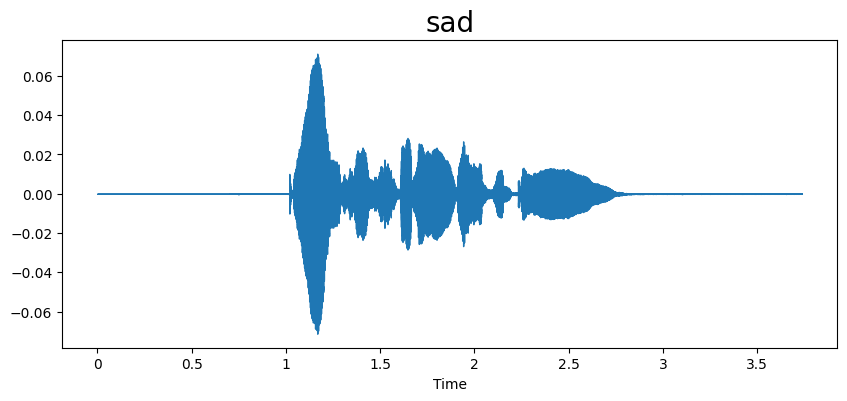

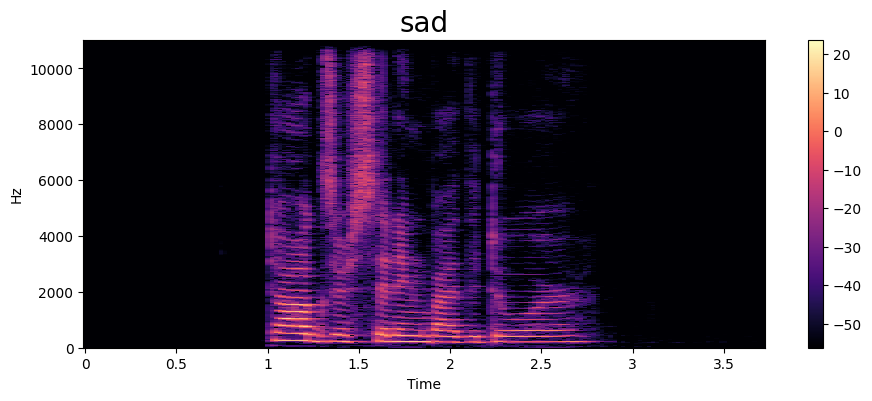

In [37]:
emotion = 'sad'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Removing Error causing possibilities

In [38]:
data_path = data_path[data_path['Emotions'] != 'calm']
data_path

Emotions                                               Path
0    surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1     neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2     disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3     disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4     neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
..        ...                                                ...
475  surprise  /kaggle/input/surrey-audiovisual-expressed-emo...
476   neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
477   neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
478     angry  /kaggle/input/surrey-audiovisual-expressed-emo...
479     happy  /kaggle/input/surrey-audiovisual-expressed-emo...

[11970 rows x 2 columns]

<Axes: xlabel='Emotions', ylabel='count'>

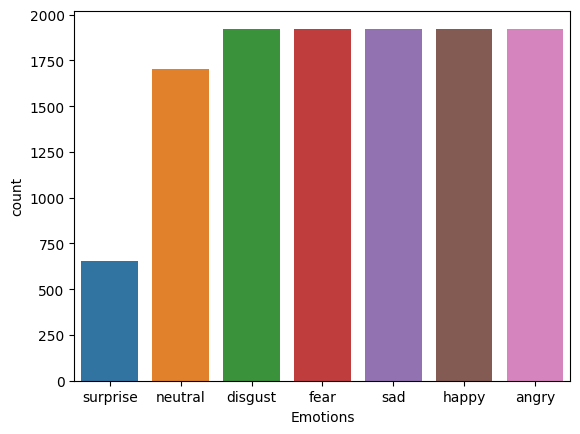

In [39]:
sns.countplot(data=data_path, x='Emotions')

## Shuffling

In [40]:
data_path = data_path.sample(frac=1)
data_path.head()

Emotions                                               Path
6470   neutral  /kaggle/input/cremad/AudioWAV/1072_IWW_NEU_XX.wav
305   surprise  /kaggle/input/surrey-audiovisual-expressed-emo...
4724     angry  /kaggle/input/cremad/AudioWAV/1037_TAI_ANG_XX.wav
3908     angry  /kaggle/input/cremad/AudioWAV/1009_ITH_ANG_XX.wav
3089      fear  /kaggle/input/cremad/AudioWAV/1051_TSI_FEA_XX.wav

In [41]:
data_path['Emotions'].value_counts()

Emotions
angry       1923
happy       1923
fear        1923
disgust     1923
sad         1923
neutral     1703
surprise     652
Name: count, dtype: int64

* Lets get even here... 
* We will use upsampling and downsampling both here
* We will keep 1800 of other emotions of the dataset and increase the number of neutral emotions.
* Let's remove the number of surprises we have for now...


## Deleting till 1800

In [42]:
# Emotions to reduce
emotions_to_reduce = ['fear', 'angry', 'happy', 'disgust', 'sad']

# Separate out the rows for emotions
reduced_data = (
    data_path[data_path['Emotions'].isin(emotions_to_reduce)]
    .groupby('Emotions')
    .head(1800)  # Keep only the first 1800 samples for these emotions
)

# Keep all samples for emotions not in emotions_to_reduce
other_data = data_path[~data_path['Emotions'].isin(emotions_to_reduce)]

# Combine the reduced emotions and the other emotions
data_path = pd.concat([reduced_data, other_data], ignore_index=True)

In [43]:
data_path['Emotions'].value_counts()

Emotions
angry       1800
fear        1800
happy       1800
disgust     1800
sad         1800
neutral     1703
surprise     652
Name: count, dtype: int64

In [44]:
data_path.Emotions.describe()

count     11355
unique        7
top       angry
freq       1800
Name: Emotions, dtype: object

## Removing the Surprises

<Axes: xlabel='Emotions', ylabel='count'>

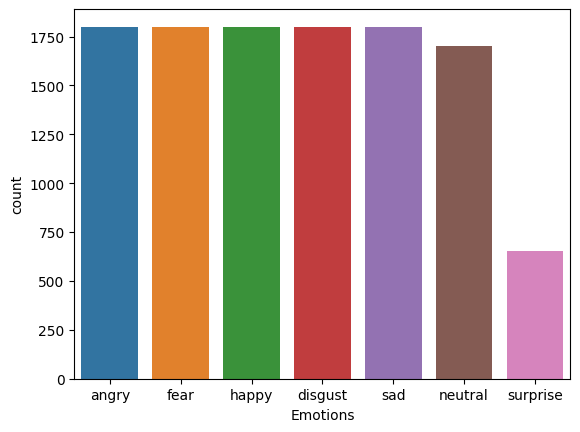

In [45]:
data_path = data_path[data_path['Emotions'] != 'surprises']
sns.countplot(data=data_path, x='Emotions')

## Duplicating Neutral Emotion Audio Samples
* We can duplicate a few random audio samples of Neutral Emotion till the count reaches that of the others

In [46]:
neutral_data = data_path[data_path['Emotions'] == 'neutral']
duplicates_needed = 1800 - len(neutral_data)
neutral_augmented = neutral_data.sample(duplicates_needed, replace=True, random_state=42)

# Combine the original and duplicated 'neutral' data
balanced_neutral_data = pd.concat([neutral_data, neutral_augmented])

# Combine all the balanced data
data_path = pd.concat([reduced_data, balanced_neutral_data])

## Verifying Count

In [47]:
print(data_path['Emotions'].value_counts())

Emotions
angry      1800
fear       1800
happy      1800
disgust    1800
sad        1800
neutral    1800
Name: count, dtype: int64


<Axes: xlabel='Emotions', ylabel='count'>

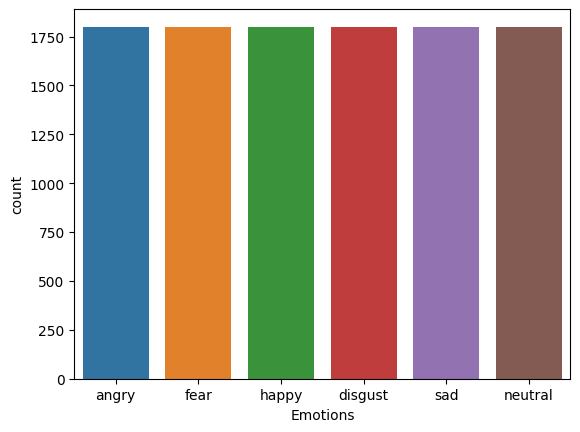

In [48]:
sns.countplot(data=data_path, x='Emotions')

# Data Augmentation

In [49]:
# # Function for adding noise to audio
# def noise(data):
#     noise_amp = 0.035*np.random.uniform()*np.amax(data)
#     data = data + noise_amp*np.random.normal(size=data.shape[0])
#     return data

# # Function for stretching the audio
# def stretch(data, rate):
#     return librosa.effects.time_stretch(data, rate=rate)

# # Function for shifting the audio
# def shift(data):
#     shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
#     return np.roll(data, shift_range)

# # Function for adding pitch to audio
# def pitch(data, sampling_rate, pitch_factor):
#     return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor*12)

In [ ]:
# GPU

def noise(data):
    # Convert data to a PyTorch tensor if it's a NumPy array
    if isinstance(data, np.ndarray):
        data = torch.tensor(data)
    
    noise_amp = 0.035 * torch.rand(1, device=data.device) * data.amax()
    data = data + noise_amp * torch.randn_like(data)
    return data

# def stretch(data, rate):
#     # Using torchaudio for time stretching
#     return torchaudio.transforms.TimeStretch(rate)(data)

# def stretch(data, rate=0.8):
#     time_stretch = T.TimeStretch()
#     return time_stretch(data, rate)

def shift(data, shift_max=1600):
    # Ensure data is a tensor
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data)  # Convert NumPy array to PyTorch tensor
    
    shift = torch.randint(-shift_max, shift_max, (1,)).item()
    return torch.roll(data, shifts=shift, dims=0)

# def pitch(data, sample_rate, pitch_factor=0):
#     # Using torchaudio for pitch shifting
#     return torchaudio.transforms.PitchShift(sample_rate, pitch_factor)(data)

# def pitch(data, sample_rate, pitch_factor=2.0):
#     pitch_shift = T.PitchShift(sample_rate=sample_rate, n_steps=pitch_factor)
#     return pitch_shift(data)

In [ ]:
# # taking any example and checking for the techniques.
# path = np.array(data_path.Path)[1]
# data, sample_rate = librosa.load(path)
# # data and sample_rate = diff per path

# Load audio data with torchaudio and move to GPU
def load_audio(path):
    waveform, sample_rate = torchaudio.load(path)
    waveform = waveform.to("cuda")  # Move data to GPU
    return waveform, sample_rate

In [52]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

### 1. Noise Injection

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

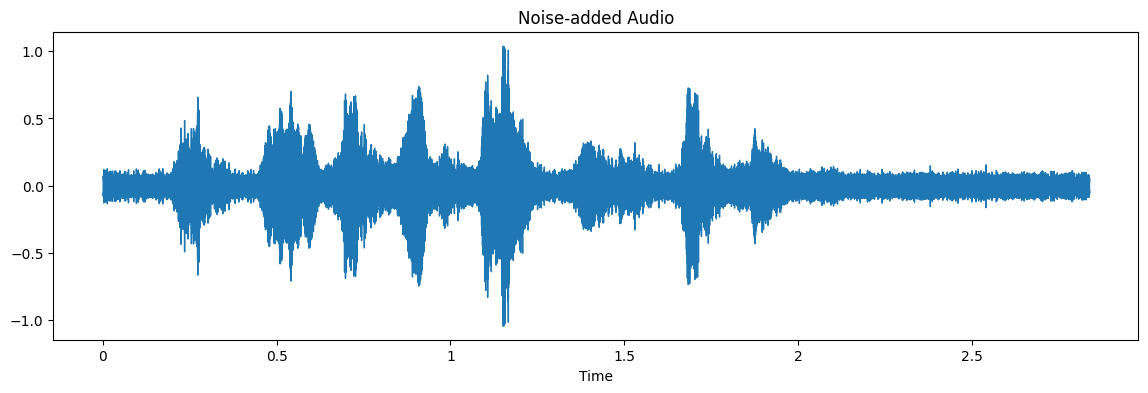

In [ ]:
# Assuming data is a NumPy array
data_tensor = torch.from_numpy(data)

# If using GPU
data_tensor = data_tensor.to("cuda")

x = noise(data_tensor)

# Convert back to NumPy array for plotting
x_numpy = x.cpu().numpy()

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x_numpy, sr=sample_rate)
plt.title("Noise-added Audio")
plt.show()

# Play augmented audio
Audio(x_numpy, rate=sample_rate)

### 2. Stretching
* Changing speed

In [55]:
# x = stretch(data, 0.7)
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

In [56]:
# # Step 1: Convert waveform to spectrogram (using a magnitude spectrogram)
# spectrogram = torch.stft(data_tensor, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)

# # Check the shape of the spectrogram
# print(spectrogram.shape)  # should be (batch_size, freq_bins, time_steps)

# # Take the magnitude of the spectrogram
# magnitude_spectrogram = spectrogram.abs()  # Now it's a real-valued spectrogram

# # Step 2: Apply time stretch (stretch factor < 1.0 means slower; > 1.0 means faster)
# rate = 0.8  # Stretch factor
# time_stretch_transform = torchaudio.transforms.TimeStretch(n_freq=513).to(data_tensor.device)
# stretched_spectrogram = time_stretch_transform(magnitude_spectrogram, rate)

# # Step 3: Convert stretched spectrogram back to waveform
# griffin_lim_transform = torchaudio.transforms.GriffinLim(n_fft=n_fft, win_length=win_length, hop_length=hop_length).to(data_tensor.device)
# stretched_waveform = griffin_lim_transform(stretched_spectrogram)

# # Convert back to NumPy array for visualization
# x_numpy = stretched_waveform.cpu().squeeze().numpy()

# # Visualization
# plt.figure(figsize=(14, 4))
# librosa.display.waveshow(y=x_numpy, sr=sample_rate)
# plt.title("Stretched Audio")
# plt.show()

# # Play stretched audio
# Audio(x_numpy, rate=sample_rate)

In [57]:
# data_tensor = torch.from_numpy(data).unsqueeze(0)

# # If using GPU
# data_tensor = data_tensor.to("cuda")

# x = stretch(data_tensor)

# x_numpy = x.cpu().numpy()

# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x_numpy, sr=sample_rate)
# Audio(x_numpy, rate=sample_rate)

### 3. Shifting

In [58]:
# x = shift(data)
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

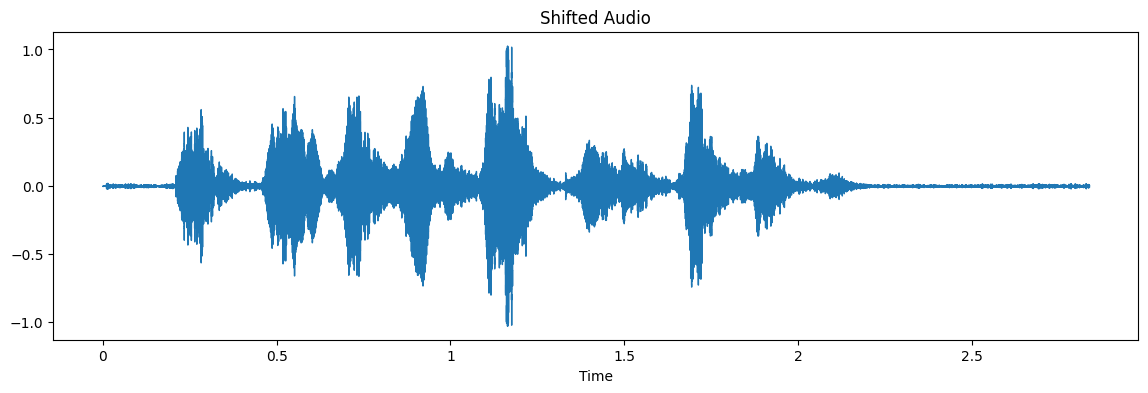

In [59]:
# Apply shifting
x = shift(data_tensor)

# Convert back to NumPy array for visualization
x_numpy = x.cpu().numpy()

# Visualization
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x_numpy, sr=sample_rate)
plt.title("Shifted Audio")
plt.show()

# Play shifted audio
Audio(x_numpy, rate=sample_rate)

### 4. Pitch

In [60]:
# x = pitch(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

In [61]:
# # Define the pitch adjustment function
# def pitch(data, sample_rate, pitch_factor=2.0):
#     transform = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=pitch_factor)
#     return transform(data.unsqueeze(0))  # Add batch dimension

# # Apply pitch adjustment
# x = pitch(data_tensor, sample_rate, pitch_factor=2.0).squeeze()  # Remove batch dimension after pitch adjustment

# # Convert back to NumPy array for visualization
# x_numpy = x.cpu().numpy()

# # Visualization
# plt.figure(figsize=(14, 4))
# librosa.display.waveshow(y=x_numpy, sr=sample_rate)
# plt.title("Pitch-shifted Audio")
# plt.show()

# # Play pitch-shifted audio
# Audio(x_numpy, rate=sample_rate)

# Feature Extraction

In [62]:
# Using GPU
def extract_features(data, sample_rate):
    # Convert tensor to NumPy array (if it's a tensor)
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()  # Move to CPU if it's on GPU and convert to numpy array
    
    result = torch.tensor([]).to('cuda')  # Start with an empty tensor on GPU
    
    # ZCR
    zcr = torch.tensor(librosa.feature.zero_crossing_rate(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, zcr), dim=0)  # Concatenate on GPU

    # ZCR (Zero Crossing Rate)
    zcr = torch.tensor(librosa.feature.zero_crossing_rate(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, zcr), dim=0)  # Concatenate on GPU

    # Chroma_stft
    stft = torch.tensor(np.abs(librosa.stft(data))).to('cuda')
    chroma_stft = torch.tensor(librosa.feature.chroma_stft(S=stft.cpu().numpy(), sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, chroma_stft), dim=0)

    # MFCC
    mfcc = torch.tensor(librosa.feature.mfcc(y=data, sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, mfcc), dim=0)

    # Root Mean Square Value
    rms = torch.tensor(librosa.feature.rms(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, rms), dim=0)

    # MelSpectogram
    mel = torch.tensor(librosa.feature.melspectrogram(y=data, sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, mel), dim=0)

    return result.cpu().numpy()  # Convert back to NumPy array if needed

In [63]:
def augment_and_extract_features(path, n_augment=100):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Extract features from the original audio
    original_features = extract_features(data, sample_rate)

    # Randomly choose an augmentation technique
    augmentation_methods = [noise, 
                            #stretch, 
                            shift
                            #, pitch
                           ]
    method = random.choice(augmentation_methods)

    # Apply the chosen augmentation
#     if method == pitch:
#         augmented_data = method(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
#     elif method == stretch:
#         augmented_data = method(data, rate=np.random.uniform(0.5, 1.5))
#     else:
#         augmented_data = method(data)

    augmented_data = method(data)
    
    # Extract features from the augmented audio
    augmented_features = extract_features(augmented_data, sample_rate)

    # Stack original and augmented features vertically
    combined_features = np.vstack((original_features, augmented_features))

    return combined_features

In [65]:
# Assuming you're using PyTorch for feature extraction and augmentations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset processing
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    features = augment_and_extract_features(path)  # Assuming this returns a list of tensors
    for feature in features:
        # Convert to PyTorch tensor if feature is a numpy array, then move to the correct device
        if isinstance(feature, np.ndarray):
            feature = torch.tensor(feature)
        # Move feature to the correct device
        feature = feature.to(device)  # PyTorch tensor, moved to GPU or CPU
        X.append(feature)
        Y.append(emotion)

# Convert list to numpy arrays if necessary
X = np.array([x.cpu().numpy() for x in X])  # Convert tensors to numpy
Y = np.array(Y)

# Shuffle the dataset
X, Y = shuffle(X, Y, random_state=42)

In [66]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.066717  0.066717  0.551892  0.571764  0.675518  0.530181  0.503376   
1  0.062006  0.062006  0.617356  0.638539  0.586583  0.662921  0.701044   
2  0.222900  0.222900  0.650850  0.708319  0.683654  0.635387  0.680394   
3  0.044798  0.044798  0.674519  0.655971  0.577303  0.610160  0.665670   
4  0.028967  0.028967  0.438992  0.367441  0.363687  0.429234  0.501296   

          7         8         9  ...           154           155  \
0  0.514097  0.595966  0.679817  ...  3.809190e-07  3.506327e-07   
1  0.581887  0.662562  0.638525  ...  4.020236e-06  3.820448e-06   
2  0.729800  0.742152  0.773001  ...  2.290609e-04  2.304617e-04   
3  0.527268  0.532697  0.594646  ...  2.011851e-05  1.912310e-05   
4  0.597932  0.483162  0.521850  ...  7.832423e-06  9.050351e-06   

            156           157           158           159           160  \
0  3.294510e-07  3.138667e-07  3.023642e-07  2.941422e-07  2.881993e-07   
1  3.674200e-06  3.557844e-06  3.468868e-06  3.401484e-06  3.350353e-06   
2  2.316040e-04  2.343428e-04  2.487122e-04  2.518529e-04  2.390183e-04   
3  1.851726e-05  1.775678e-05  1.744032e-05  1.706163e-05  1.677275e-05   
4  3.327883e-06  4.743264e-06  3.654576e-06  6.370366e-06  7.853617e-06   

            161           162   labels  
0  2.843557e-07  2.819939e-07  disgust  
1  3.317695e-06  3.295007e-06  disgust  
2  2.188634e-04  2.264438e-04  disgust  
3  1.661851e-05  1.651578e-05    happy  
4  2.203700e-06  1.554750e-07      sad  

[5 rows x 164 columns]

In [67]:
print(data_path.shape)
data_path.head()

(10800, 2)


Emotions                                               Path
4724    angry  /kaggle/input/cremad/AudioWAV/1037_TAI_ANG_XX.wav
3908    angry  /kaggle/input/cremad/AudioWAV/1009_ITH_ANG_XX.wav
3089     fear  /kaggle/input/cremad/AudioWAV/1051_TSI_FEA_XX.wav
2695    angry  /kaggle/input/cremad/AudioWAV/1080_MTI_ANG_XX.wav
800     angry  /kaggle/input/cremad/AudioWAV/1030_TSI_ANG_XX.wav

In [68]:
len(X), len(Y)

(21600, 21600)

In [69]:
data_path.shape

(10800, 2)

We have applied data augmentation and extracted the features for each audio files and saved them.

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [70]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [71]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

splitting it in the ratio 3:1

In [72]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15120, 163), (15120, 6), (6480, 163), (6480, 6))

In [73]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15120, 163), (15120, 6), (6480, 163), (6480, 6))

In [74]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15120, 163, 1), (15120, 6), (6480, 163, 1), (6480, 6))

In [ ]:
# y = y.toarray()
# y.shape

# CNN Model

In [75]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 163, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 82, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 82, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,222 (2.13 MB)

 Trainable params: 557,222 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
y_train.shape

(15120, 6)

In [77]:
y_test.shape

(6480, 6)

In [78]:
x_test.shape

(6480, 163, 1)

In [79]:
x_train.shape

(15120, 163, 1)

In [80]:
with tf.device('/device:GPU:0'):
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, 
                             patience=2, min_lr=0.0000001)
    history=model.fit(x_train, y_train, batch_size=128, epochs=120, 
                      validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/120


I0000 00:00:1731265765.797129     170 service.cc:145] XLA service 0x7dfbf400d420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731265765.797188     170 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-10 19:09:29.141751: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[128,256,1,82]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,1,82]{3,2,1,0}, f32[256,256,1,5]{3,2,1,0}, f32[256]{0}), window={size=1x5 pad=0_0x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-10 19:09:29.182008: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.040366998s
Trying

 21/119 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2374 - loss: 1.7588

I0000 00:00:1731265774.082256     170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.2697 - loss: 1.6785 - val_accuracy: 0.3949 - val_loss: 1.4538 - learning_rate: 0.0010
Epoch 2/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3764 - loss: 1.4606 - val_accuracy: 0.4639 - val_loss: 1.3259 - learning_rate: 0.0010
Epoch 3/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4227 - loss: 1.3907 - val_accuracy: 0.4735 - val_loss: 1.2923 - learning_rate: 0.0010
Epoch 4/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4635 - loss: 1.3185 - val_accuracy: 0.5097 - val_loss: 1.2153 - learning_rate: 0.0010
Epoch 5/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4863 - loss: 1.2576 - val_accuracy: 0.5222 - val_loss: 1.1683 - learning_rate: 0.0010
Epoch 6/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5089 - loss: 1.2168 - val_accuracy: 0.5228 - val_loss: 1.1735 - learning_rate: 0.0010
Epoch 7/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5137 - loss: 1.1946 - val

## Accuracy of Model

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7210 - loss: 1.5030
Accuracy of our model on test data :  71.9753086566925 %


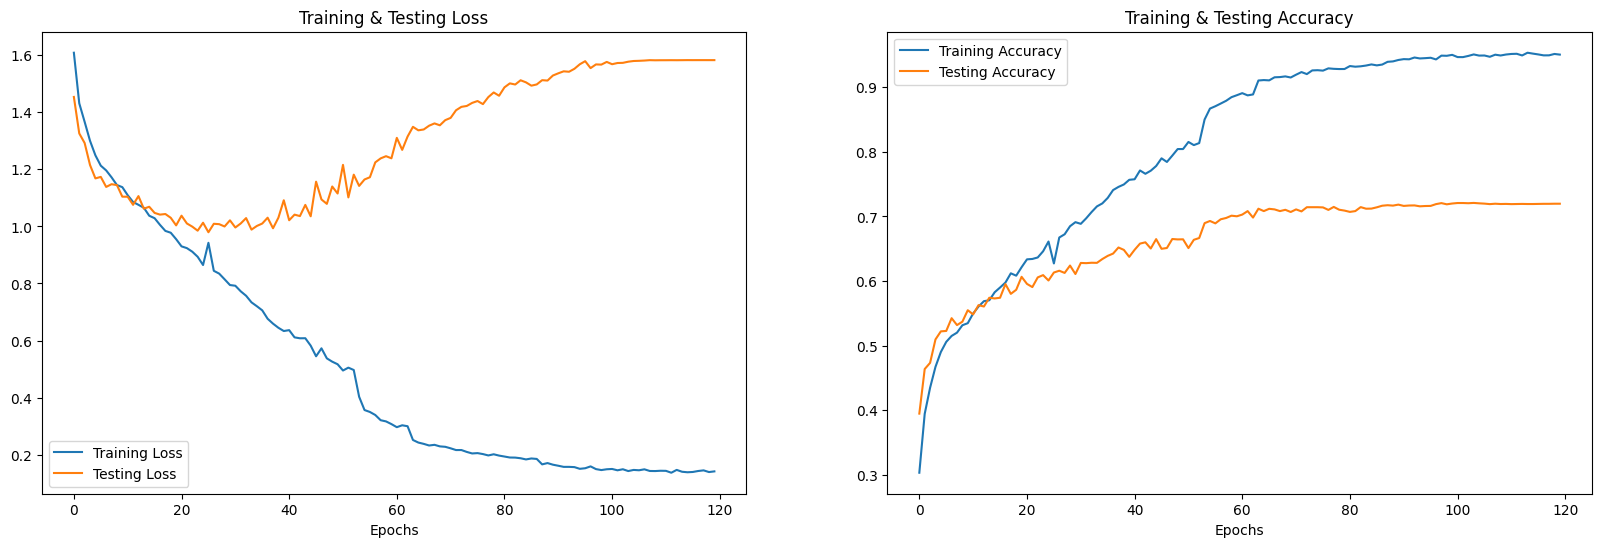

In [81]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

# epochs = [i for i in range(20)]
epochs = range(len(history.history['loss']))  # This will match the length of the history data
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## Prediction

In [82]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [83]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            happy         happy
1            angry         angry
2             fear       neutral
3          disgust         happy
4            angry         happy
5          disgust       disgust
6            angry         angry
7            angry         angry
8              sad           sad
9          neutral       neutral

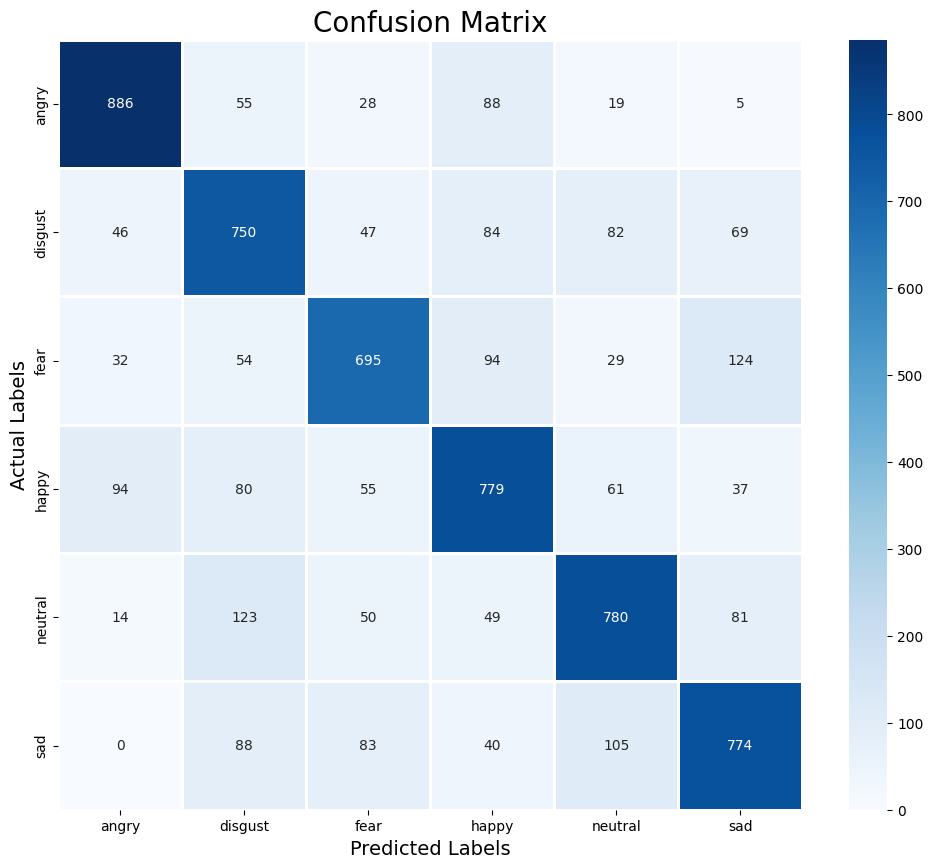

In [84]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.83      0.82      0.82      1081
     disgust       0.65      0.70      0.67      1078
        fear       0.73      0.68      0.70      1028
       happy       0.69      0.70      0.70      1106
     neutral       0.72      0.71      0.72      1097
         sad       0.71      0.71      0.71      1090

    accuracy                           0.72      6480
   macro avg       0.72      0.72      0.72      6480
weighted avg       0.72      0.72      0.72      6480



* Our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
* We overall achieved 72% accuracy on our test data and its decent.